- refactor the files... e.g. simulation code split between standard DGPs and code that makes data, rename hte_caret, move iptw/ipcw to different places
- implement value and c-index functions. (remember: ipcw is needed b/c KM by itself doesn't adjust for *informative* censoring)
- test everything together
- run sims and look at results

In [344]:
library(plyr)
library(magrittr)
library(distr)
library(distrEx)
library(gbm)
library(Matching)
library(caret)
library(tidyverse)
library(BART)
source("R/simulation_scenarios.R")
source("R/hte_caret.R")
source("R/eval_hte_cv.R")
source("R/hte_cv.R")

In [268]:
DGP = list()
n = 5

X1 = Norm(mean=1)
X2 = Norm(mean=1)
DGP$X = list(X1, X2)

DGP$f_W_x = function(x, w) {
    logit_p = x[1] + x[2]
    p = exp(logit_p) / (1 + exp(logit_p))
    Binom(prob=p)
}

DGP$f_Y_xw = function(x, w) {
    if(w) {
        Weibull(scale= exp(x[2]), 
                shape=1.2)
    } else {
        Weibull(scale= exp(x[1]), 
                shape=1.2)
    }
}

DGP$f_C_xw = function(x, w) {
    Weibull(scale=4, 
            shape=1.4)
}

In [337]:
datas = setup_data(DGP, 1000, 5000, 3)

In [338]:
models = list(
#     rf_spec = list(method = two_model_surv_rf,
#                    tune_grid = expand.grid(num.trees = 500,
#                                            mtry = 1,
#                                            min.node.size = 3)),
    gbm_spec = list(method = gbm_ph,
                    tune_grid = expand.grid(n.trees = seq(1,1001,20), 
                                            interaction.depth=3, 
                                            shrinkage = 0.05, 
                                            n.minobsinnode=3)),
    bart_spec = list(method=one_model_surv_bart,
                     tune_grid=expand.grid(n_times=10,
                                           power=2,
                                           base=0.95,
                                           ntree=100,
                                           ndpost=1000,
                                           nskip=250))
)
estimates = datas %$% get_estimates(data, models, cv_index, test_index)

        t_train d_train
1   0.206914479    TRUE
2   1.351013025    TRUE
3   1.060940301    TRUE
4   0.002047837    TRUE
5   0.206914479   FALSE
6   0.002047837    TRUE
7   1.690270302    TRUE
8   0.464762585    TRUE
9   2.143164343   FALSE
10  2.857754809    TRUE
11  0.765258127    TRUE
12  0.002047837    TRUE
13  2.857754809   FALSE
14  1.060940301    TRUE
15  0.464762585    TRUE
16  2.857754809    TRUE
17  0.765258127   FALSE
18  1.351013025   FALSE
19  0.206914479    TRUE
20  0.464762585   FALSE
21  0.002047837    TRUE
22  0.002047837   FALSE
23  0.464762585    TRUE
24  2.143164343    TRUE
25  0.464762585   FALSE
26  0.765258127    TRUE
27  0.765258127   FALSE
28  1.060940301   FALSE
29  0.464762585    TRUE
30  0.002047837    TRUE
31  0.765258127    TRUE
32  3.920456416    TRUE
33  0.002047837    TRUE
34  2.857754809    TRUE
35  2.857754809    TRUE
36  3.920456416   FALSE
37  3.920456416    TRUE
38  3.920456416   FALSE
39  2.857754809    TRUE
40  1.690270302   FALSE
41  3.920456416 

In [345]:
metrics =  estimates %$% get_metrics(cv_estimates, test_estimates, datas$aux_data) 

Warning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vector

In [340]:
estimates$test_estimates %>% pull(model) %>% unique

[1] "gbm_ph~1~3~0.05~3"                         
 [2] "gbm_ph~21~3~0.05~3"                        
 [3] "gbm_ph~41~3~0.05~3"                        
 [4] "gbm_ph~61~3~0.05~3"                        
 [5] "gbm_ph~81~3~0.05~3"                        
 [6] "gbm_ph~101~3~0.05~3"                       
 [7] "gbm_ph~121~3~0.05~3"                       
 [8] "gbm_ph~141~3~0.05~3"                       
 [9] "gbm_ph~161~3~0.05~3"                       
[10] "gbm_ph~181~3~0.05~3"                       
[11] "gbm_ph~201~3~0.05~3"                       
[12] "gbm_ph~221~3~0.05~3"                       
[13] "gbm_ph~241~3~0.05~3"                       
[14] "gbm_ph~261~3~0.05~3"                       
[15] "gbm_ph~281~3~0.05~3"                       
[16] "gbm_ph~301~3~0.05~3"                       
[17] "gbm_ph~321~3~0.05~3"                       
[18] "gbm_ph~341~3~0.05~3"                       
[19] "gbm_ph~361~3~0.05~3"                       
[20] "gbm_ph~381~3~0.05~3"                       
[21] "gbm_ph~401~3~0.05~3"                       
[22] "gbm_ph~421~3~0.05~3"                       
[23] "gbm_ph~441~3~0.05~3"                       
[24] "gbm_ph~461~3~0.05~3"                       
[25] "gbm_ph~481~3~0.05~3"                       
[26] "gbm_ph~501~3~0.05~3"                       
[27] "gbm_ph~521~3~0.05~3"                       
[28] "gbm_ph~541~3~0.05~3"                       
[29] "gbm_ph~561~3~0.05~3"                       
[30] "gbm_ph~581~3~0.05~3"                       
[31] "gbm_ph~601~3~0.05~3"                       
[32] "gbm_ph~621~3~0.05~3"                       
[33] "gbm_ph~641~3~0.05~3"                       
[34] "gbm_ph~661~3~0.05~3"                       
[35] "gbm_ph~681~3~0.05~3"                       
[36] "gbm_ph~701~3~0.05~3"                       
[37] "gbm_ph~721~3~0.05~3"                       
[38] "gbm_ph~741~3~0.05~3"                       
[39] "gbm_ph~761~3~0.05~3"                       
[40] "gbm_ph~781~3~0.05~3"                       
[41] "gbm_ph~801~3~0.05~3"                       
[42] "gbm_ph~821~3~0.05~3"                       
[43] "gbm_ph~841~3~0.05~3"                       
[44] "gbm_ph~861~3~0.05~3"                       
[45] "gbm_ph~881~3~0.05~3"                       
[46] "gbm_ph~901~3~0.05~3"                       
[47] "gbm_ph~921~3~0.05~3"                       
[48] "gbm_ph~941~3~0.05~3"                       
[49] "gbm_ph~961~3~0.05~3"                       
[50] "gbm_ph~981~3~0.05~3"                       
[51] "gbm_ph~1001~3~0.05~3"                      
[52] "one_model_surv_bart~10~2~0.95~100~1000~250"

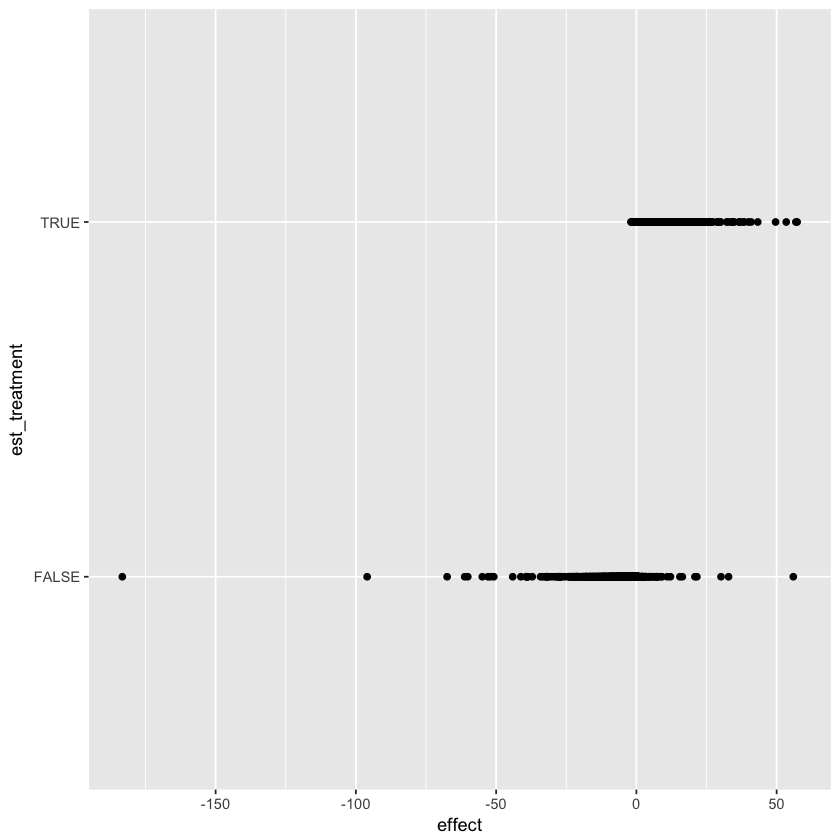

In [353]:
estimates$test_estimates %>% 
#     filter(model == "two_model_surv_rf~1000~1~3") %>%
    filter(model == "gbm_ph~81~3~0.05~3") %>%
#     filter(model == "one_model_surv_bart~10~2~0.95~100~1000~250") %>%
    inner_join(datas$aux_data, by="subject") %$%
qplot(effect, est_treatment)
# cor(effect, est_effect)

Warning message:
: Too many values at 3 locations: 52, 104, 156

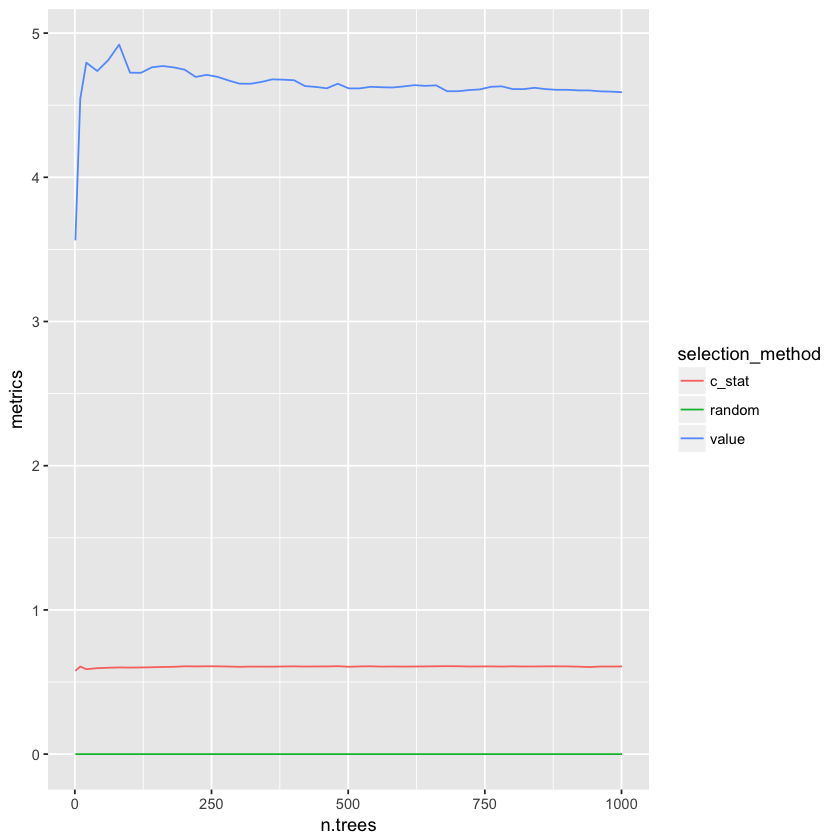

In [346]:
metrics$cv_metrics %>%
    separate(model, c("model", names(models$gbm_spec$tune_grid)), sep="~") %>%
    mutate(n.trees = as.numeric(n.trees)) %>%
# data.frame %>% str
ggplot(aes(x=n.trees, y=metrics, color=selection_method)) + 
    geom_line()

Warning message:
: Too many values at 1 locations: 52

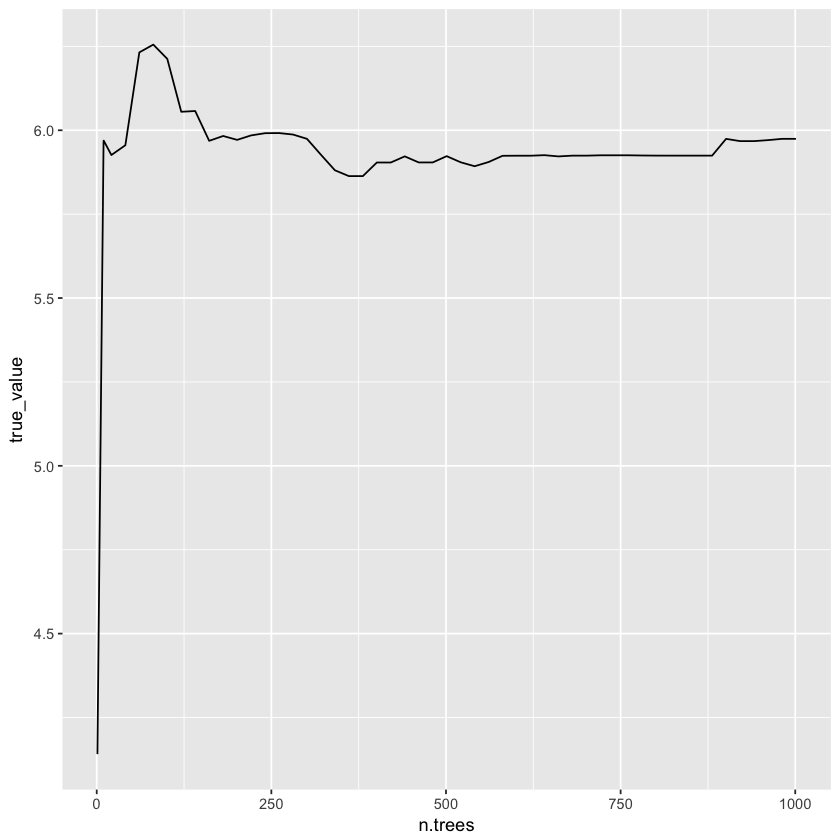

In [347]:
metrics$test_metrics %>%
    separate(model, c("model", names(models$gbm_spec$tune_grid)), sep="~") %>%
    mutate(n.trees = as.numeric(n.trees)) %>%
# data.frame %>% str
ggplot(aes(x=n.trees, y=true_value)) + 
    geom_line()

In [356]:
metrics$test_metrics %>%
    filter(model == "gbm_ph~81~3~0.05~3" | model == "one_model_surv_bart~10~2~0.95~100~1000~250") %>%
data.frame

,model,true_value
1,gbm_ph~81~3~0.05~3,6.255283
2,one_model_surv_bart~10~2~0.95~100~1000~250,5.969163


In [348]:
metrics$true_selection_metrics %>% data.frame

,model,selection_method,true_value
1,gbm_ph~681~3~0.05~3,c_stat,5.924389
2,gbm_ph~701~3~0.05~3,random,5.924389
3,gbm_ph~81~3~0.05~3,value,6.255283
4,gbm_ph~81~3~0.05~3,oracle_selector_true_value,6.255283
5,truth,oracle,6.364769
6,harm,demon,2.019138
